In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import interpolation
from collections import defaultdict
from scipy.stats import circmean
import forward_models_causal_inference
from custom_causal_inference import CustomCausalInference
import utils

class DataPoint:
    def __init__(self, s_n, s_n_1, r_n, r_n_1):
        self.s_n = s_n
        self.s_n_1 = s_n_1  
        self.r_n = r_n
        self.r_n_1 = r_n_1
    def __lt__(self, other):
        return self.s_n < other.s_n
    def to_numpy(self):
        return np.array([self.s_n, self.s_n_1, self.r_n])

gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'

In [2]:
with open(gam_data_path, 'rb') as f:
    gam_data = pickle.load(f)
r_n_key = 'r_n_full_cleaned'
len(gam_data[r_n_key]), len(gam_data['s_n']), gam_data.keys()

(24219,
 24219,
 dict_keys(['r_n', 'pred_pairs', 'reg_dict', 'x_n', 'y_n', 'alpha', 'V_0', 'eta_0', 'Lambda_0', 'beta_0', 'V_n', 'eta_n', 'Lambda_n', 'beta_n', 'Y', 'Mean_error_covariance', 'Covariance_matrix', 'beta_0_contour', 'r_squ', 'posterior_contours', 'ranges', 'coef_inds', 'reg_list', 'full_X', 'full_pred', 'non_x_pred', 'pdf_mat', 'full_pdf_mat', 'full_vec_mat', 's_impacts', 'residual_variance', 'r_n_full_cleaned', 's_n']))

In [3]:
with open('./uniform_model_base_inv_kappa_free.pkl', 'rb') as f:
    Peter_u_map = pickle.load(f)
Peter_u_map.keys()

dict_keys(['samples', 'responses', 'sim_responses', 'seed', 'lr', 'log_u_sigma', 'pdf_centers', 'pdf_log_weights', 'pdf_log_widths', 'sim_hist', 'pdf', 'grid', 'losses'])

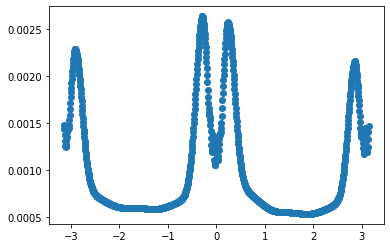

In [4]:
plt.plot(Peter_u_map['grid'], Peter_u_map['pdf'], 'o', label='Peter uniform model')

In [5]:
# Create dataset with s_n, s_n_1, r_n, r_n_1
serial_dep_data = np.zeros((len(gam_data['s_n'])-1, 5))
for index in range(len(gam_data['s_n'])-1):
    serial_dep_data[index, :] = np.array([gam_data['s_n'][index+1], gam_data['s_n'][index], gam_data[r_n_key][index+1], gam_data[r_n_key][index], index+1])

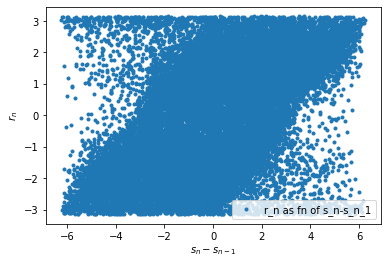

In [6]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

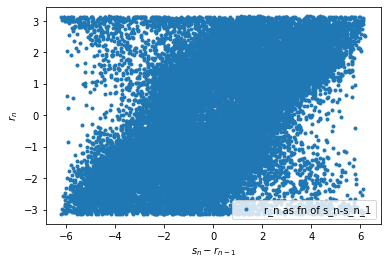

In [7]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 3], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-r_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

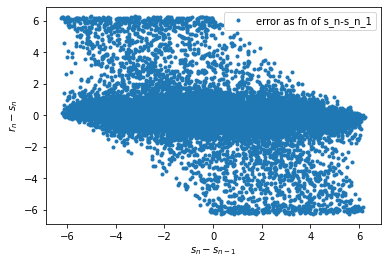

In [8]:
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2] - serial_dep_data[order_sn, 0], '.', label='error as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n-s_n$')
plt.legend()
plt.show()

In [9]:
def sn_to_mean_rn_map(s_ns, r_ns, sn_grid=None):
    if sn_grid is None:
        sn_grid = np.linspace(-np.pi, np.pi, 1000)
    responses = defaultdict(list)
    for sn, rn in zip(s_ns, r_ns):
        index_in_grid = int(interpolation.find_closest_mu_bs(mu=sn, mus=sn_grid))
        responses[index_in_grid].append(rn)
    mean_responses = np.array([circmean(high=np.pi, low=-np.pi, samples=responses[i]) for i in range(len(sn_grid))])
    return sn_grid, mean_responses

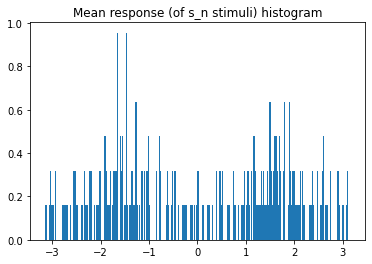

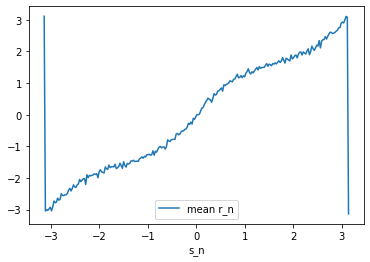

In [26]:
# sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=Peter_u_map['grid'])
sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=np.linspace(-np.pi, np.pi, 250))   
bin_counts, _, _ = plt.hist(mean_r_n, bins=np.linspace(-np.pi, np.pi, len(sn_grid)+1), density=True)
plt.title('Mean response (of s_n stimuli) histogram')
plt.show()
# handle wrap
plt.plot(sn_grid, mean_r_n, label='mean r_n')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'pdf': bin_counts, 'angle_to_u': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

In [19]:
utils.circular_dist(sn_grid[0], mean_r_n[0]), abs(sn_grid[0]-mean_r_n[0]), 2*np.pi

(0.11738658802289503, 6.165798719156691, 6.283185307179586)

0 -3.141592653589793 3.1142063856433273
not monotonic: (3, -3.0266238324494905, -3.00552885900289, -3.0658916257924487)
not monotonic: (6, -3.038946287820951, -2.9250223560036184, -2.9901905979951042)
not monotonic: (9, -2.782218340180577, -2.729488425834343, -2.91448957019776)
not monotonic: (12, -2.7015728655633504, -2.6380838335220673, -2.8387885424004153)
not monotonic: (15, -2.5478504940986992, -2.4991153856056334, -2.763087514603071)
not monotonic: (16, -2.5606884225382722, -2.5478504940986992, -2.737853838670623)
not monotonic: (18, -2.5340206906304044, -2.5336202560184535, -2.6873864868057264)
not monotonic: (22, -2.4117281795625285, -2.3283497039062926, -2.586451783075934)
not monotonic: (25, -2.283173659305609, -2.2177279876370646, -2.5107507552785897)
not monotonic: (26, -2.3007579617815836, -2.283173659305609, -2.4855170793461414)
not monotonic: (30, -2.1179803588230524, -2.0464667508613865, -2.384582375616349)
not monotonic: (34, -2.2063382453718656, -2.021286389107458, -2

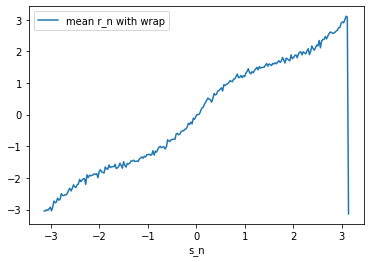

In [27]:
mean_r_n_wrap = np.array(mean_r_n)
for idx, (sn, mrn) in enumerate(zip(sn_grid, mean_r_n)):
    if abs(sn - mrn) > np.pi:
        print(idx, sn, mrn)
        mean_r_n_wrap[idx] = np.min(mean_r_n_wrap[idx:idx+7])
    if (idx > 0) and (mean_r_n_wrap[idx] < mean_r_n_wrap[idx-1]):
        print(f'not monotonic: {idx, mean_r_n_wrap[idx], mean_r_n_wrap[idx-1], sn}')
plt.plot(sn_grid, mean_r_n_wrap, label='mean r_n with wrap')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'f': mean_r_n_wrap, 'f_inv': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

In [11]:
stimuli_grid = np.linspace(-np.pi, np.pi, 250)
t_index = 0  # use r_n_1 as regressor
causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
        model=CustomCausalInference(decision_rule='mean'),
        angle_gam_data_path=gam_data_path,
        unif_fn_data_path='./mean_response_map.pkl',)
mean_response_map = causal_inference_estimator.unif_map

In [12]:
def get_repulsion_mat(sns, ts, rns):
    repulsion = np.zeros_like(sns)
    for idx, (t, s_n, r_n) in enumerate(zip(ts, sns, rns)):
        us_n = mean_response_map.angle_space_to_unif_space(s_n)
        ut = mean_response_map.angle_space_to_unif_space(t)
        ur_n = mean_response_map.angle_space_to_unif_space(r_n)
        if utils.circular_dist(us_n, ut) < utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n):
            repulsion[idx] = utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n) - utils.circular_dist(us_n, ut)
    return repulsion

In [13]:
def plot_heatmap_uspace(data, usns, uts, grid_dim, title):
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
            data, shading='auto', cmap='magma')
    plt.colorbar(label='circular distance to r_n(t, s_n)')
    plt.xlabel('us_n')
    plt.ylabel('ut')
    plt.title(title)
    plt.show()

Comparing with fits

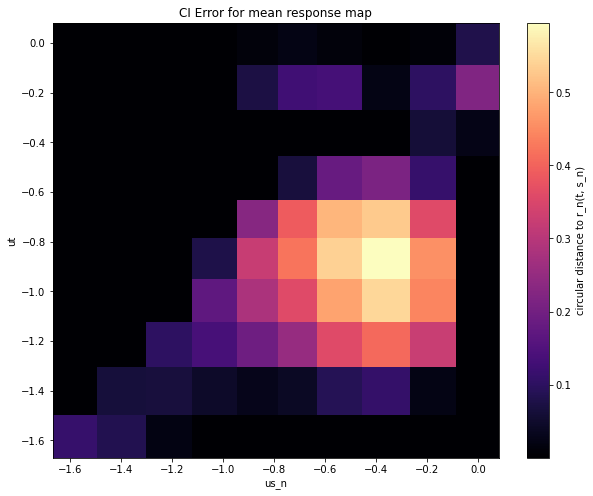

In [14]:
grid_sz = 100
optimal_kappa_pairs_filepath = f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_pc_filepath = f'./learned_data/min_error_for_idx_pc_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_filepath = f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}.pkl'
s_ns_filepath = f'./learned_data/selected_s_n_{grid_sz}_t{t_index}.npy'
ts_filepath = f'./learned_data/selected_t_{grid_sz}_t{t_index}.npy'
r_ns_filepath = f'./learned_data/selected_r_n_{grid_sz}_t{t_index}.npy'
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)
grid_dim = int(np.sqrt(s_ns.shape[0]))
err_mat = np.zeros_like(s_ns).reshape((grid_dim, grid_dim))
for i in range(grid_dim):
    for j in range(grid_dim):
        err_mat[i, j] = min_error_for_idx['sn'][i*grid_dim+j]
plot_heatmap_uspace(err_mat, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='CI Error for mean response map')

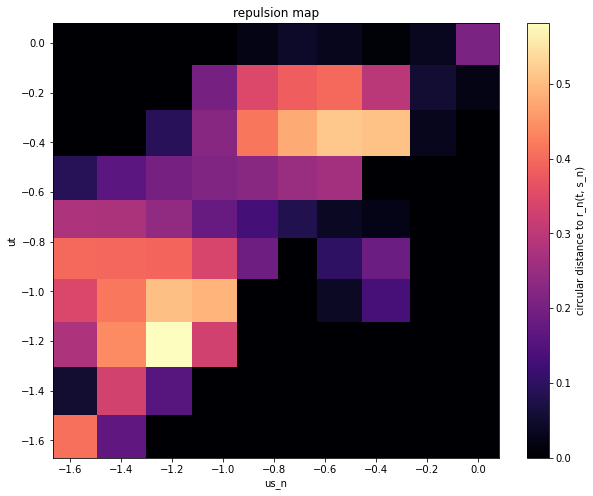

In [15]:
repulsion = get_repulsion_mat(s_ns, ts, r_ns).reshape((grid_dim, grid_dim))
plot_heatmap_uspace(repulsion, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='repulsion map')